# GCNN for Social Network Analysis

## Installation & Imports

In [ ]:
# PyTorch Geometric installation for Colab (CPU-only for simplicity)
!pip install torch-scatter torch-sparse torch-geometric torch-cluster -q

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import KarateClub, Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.5 MB/s eta 0:00:00


## Load Datasets

In [2]:
karate_dataset = KarateClub()
karate_data = karate_dataset

In [3]:
cora_dataset = Planetoid(root='/tmp/Cora', name='Cora')
cora_data = cora_dataset

Processing...
Done!


## Plotting Node Degree Histogram

In [16]:
def plot_degree_histogram(data, title):
    G = to_networkx(data[0], to_undirected=True)
    degrees = [d for n, d in G.degree()]
    plt.figure(figsize=(5,3))
    plt.hist(degrees, bins=np.arange(min(degrees), max(degrees)+2)-0.5, color='#3399E6', rwidth=0.8)
    plt.xlabel("Node Degree")
    plt.ylabel("Frequency")
    plt.title(f"Node Degree Distribution ({title})")
    plt.show()


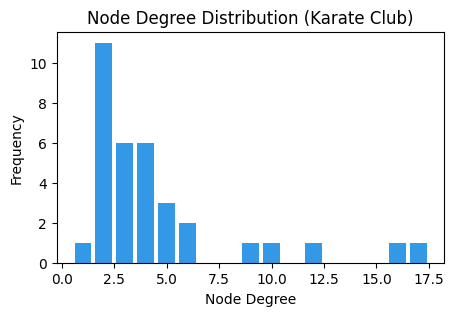

In [17]:
plot_degree_histogram(karate_data, 'Karate Club')

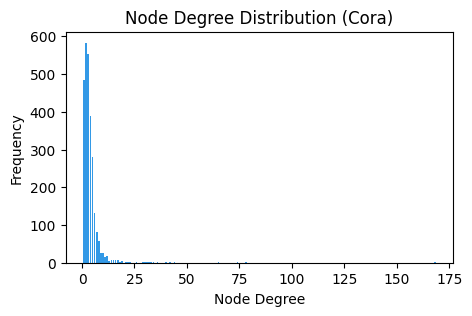

In [18]:
plot_degree_histogram(cora_data, 'Cora')

## Visualize the Graph

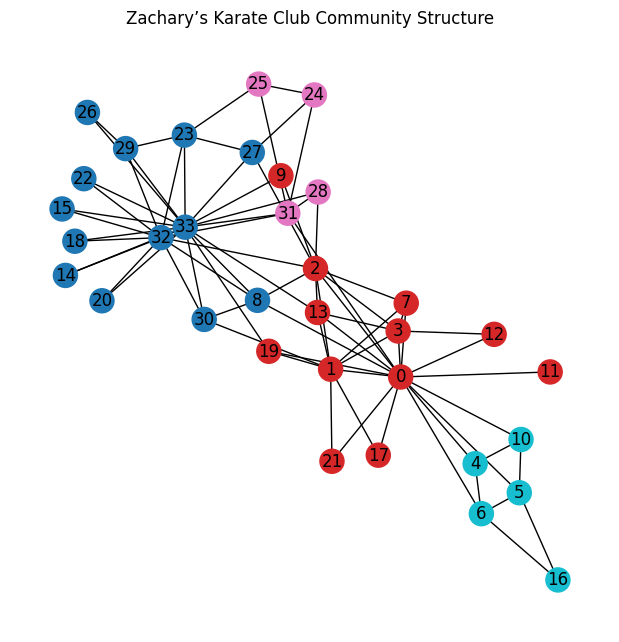

In [5]:
G = to_networkx(karate_dataset[0], to_undirected=True)
plt.figure(figsize=(6,6))
nx.draw(G, node_color=karate_dataset[0].y, cmap=plt.cm.tab10, with_labels=True)
plt.title('Zachary’s Karate Club Community Structure')
plt.show()

## Build a GCNN Model

In [6]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


## Train on the Karate Club Graph (Community Detection/Clustering)

Epoch 0, Loss: 1.3703
Epoch 30, Loss: 0.5400
Epoch 60, Loss: 0.1562
Epoch 90, Loss: 0.0631
Epoch 120, Loss: 0.0324


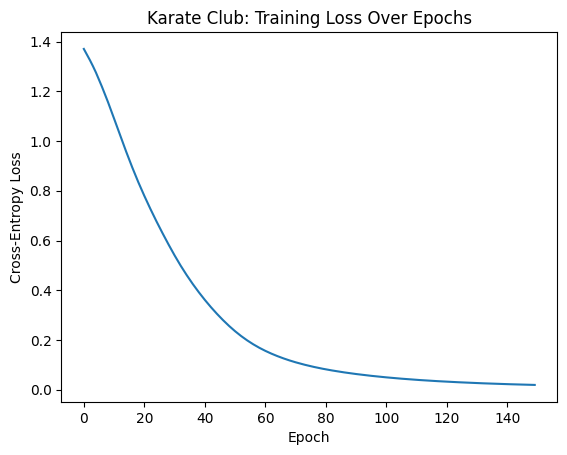

In [32]:
karate_model = GCN(karate_data.num_node_features, 16, karate_dataset.num_classes)
optimizer = torch.optim.Adam(karate_model.parameters(), lr=0.01)

losses = []
for epoch in range(150):
    optimizer.zero_grad()
    out = karate_model(karate_data.x, karate_data.edge_index)
    # Use all labels (tiny graph; demo only)
    loss = F.cross_entropy(out, karate_data.y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 30 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

plt.plot(losses)
plt.title("Karate Club: Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.show()

## Feature Influence / Saliency Visualization

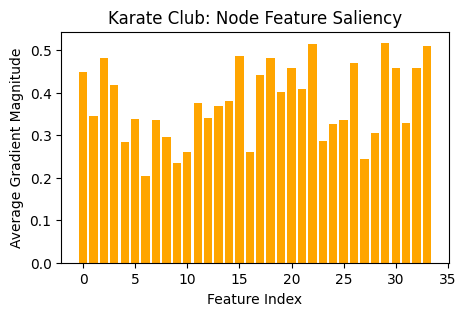

In [26]:
def feature_saliency(model, data):
    data.x.requires_grad = True
    logits = model(data.x, data.edge_index)
    loss = F.cross_entropy(logits, data.y)
    loss.backward()
    saliency = data.x.grad.abs().mean(dim=0).cpu().numpy()
    plt.figure(figsize=(5,3))
    plt.bar(range(len(saliency)), saliency, color='#FFA500')
    plt.title("Karate Club: Node Feature Saliency")
    plt.xlabel("Feature Index")
    plt.ylabel("Average Gradient Magnitude")
    plt.show()
    data.x.requires_grad = False

feature_saliency(karate_model, karate_data)

## Visualize Embeddings / Results

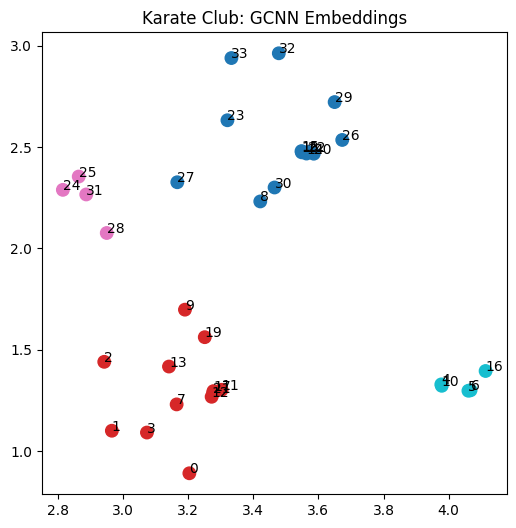

In [27]:
@torch.no_grad()
def plot_karate_embeddings(model, data):
    logits = model(data.x, data.edge_index)
    # Use embeddings before softmax
    embeddings = logits.numpy()
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=42)
    z = tsne.fit_transform(embeddings)
    plt.figure(figsize=(6,6))
    plt.scatter(z[:,0], z[:,1], c=data.y, cmap=plt.cm.tab10, s=80)
    for i, label in enumerate(data.y):
        plt.annotate(str(i), (z[i,0], z[i,1]))
    plt.title('Karate Club: GCNN Embeddings')
    plt.show()

plot_karate_embeddings(karate_model, karate_data)

## Community Detection Visualization
Uses NetworkX’s built-in methods.

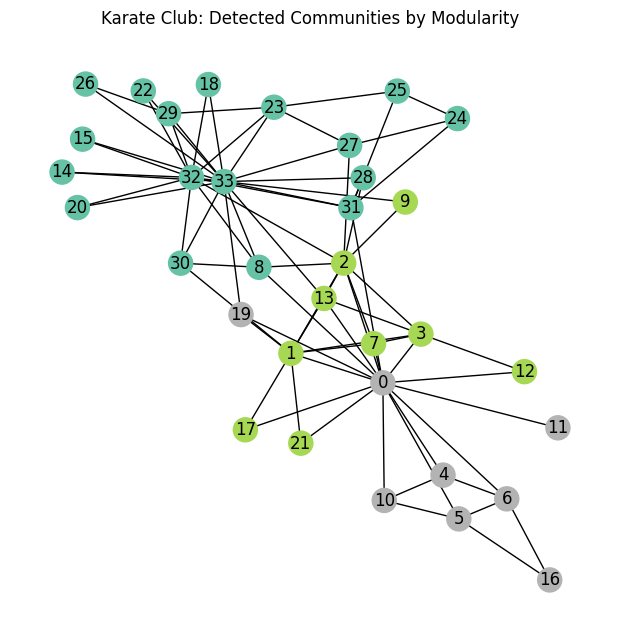

In [20]:
from networkx.algorithms.community import greedy_modularity_communities

G = to_networkx(karate_data[0], to_undirected=True)
communities = list(greedy_modularity_communities(G))
node_colors = np.zeros(G.number_of_nodes())
for i, comm in enumerate(communities):
    for node in comm:
        node_colors[node] = i

plt.figure(figsize=(6,6))
nx.draw(G, node_color=node_colors, cmap=plt.cm.Set2, with_labels=True)
plt.title("Karate Club: Detected Communities by Modularity")
plt.show()


## Node Classification on Cora

Epoch 0, Loss: 1.9379
Epoch 20, Loss: 0.1088
Epoch 40, Loss: 0.0147
Epoch 60, Loss: 0.0144
Epoch 80, Loss: 0.0169


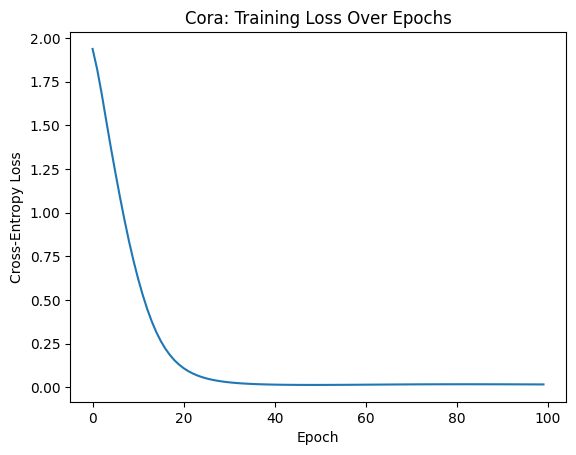

In [33]:
# Build model
cora_model = GCN(cora_dataset.num_node_features, 16, cora_dataset.num_classes)
optimizer = torch.optim.Adam(cora_model.parameters(), lr=0.01,
                             weight_decay=5e-4)

# Masks provided for train/test split
losses = []
for epoch in range(100):
    cora_model.train()
    optimizer.zero_grad()
    out = cora_model(cora_data.x, cora_data.edge_index)
    loss = F.cross_entropy(out[cora_data.train_mask],
                           cora_data.y[cora_data.train_mask])
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

plt.plot(losses)
plt.title("Cora: Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.show()

In [29]:
@torch.no_grad()
def test():
    cora_model.eval()
    logits = cora_model(cora_data.x, cora_data.edge_index)
    pred = logits.argmax(dim=1)
    accs = []
    for mask in [cora_data.train_mask,
                 cora_data.val_mask,
                 cora_data.test_mask]:
        correct = (pred[mask] == cora_data.y[mask]).sum()
        accs.append(int(correct) / int(mask.sum()))
    print(f'Train: {accs[0]:.3f}, Val: {accs[1]:.3f}, Test: {accs[2]:.3f}')

test()

Train: 1.000, Val: 0.786, Test: 0.807


## Visualize Node Embeddings (Cora)

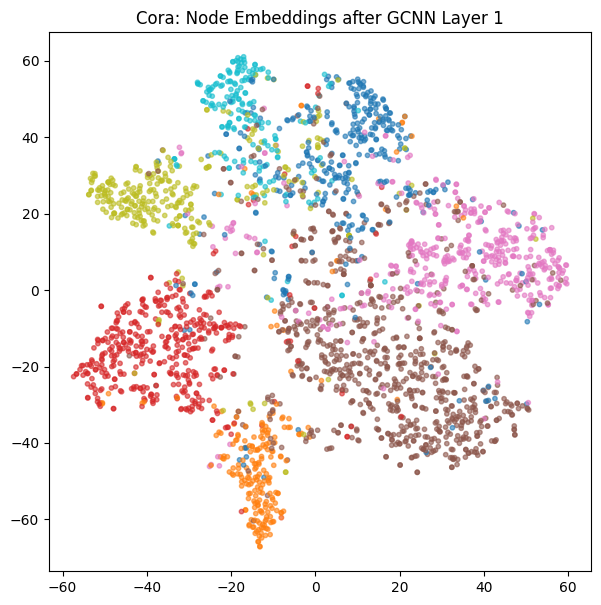

In [30]:
@torch.no_grad()
def plot_cora_embeddings(model, data):
    model.eval()
    logits = model.conv1(data.x, data.edge_index)  # First layer embeddings
    emb = logits.numpy()
    from sklearn.manifold import TSNE
    z = TSNE(n_components=2, random_state=0).fit_transform(emb)
    plt.figure(figsize=(7,7))
    plt.scatter(z[:, 0], z[:, 1], c=data.y, cmap=plt.cm.tab10, s=10, alpha=0.6)
    plt.title('Cora: Node Embeddings after GCNN Layer 1')
    plt.show()

plot_cora_embeddings(cora_model, cora_data)

## Confusion Matrix (for node classification)

<Figure size 600x600 with 0 Axes>

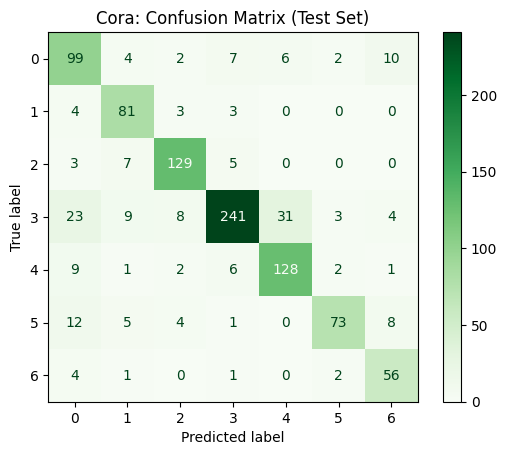

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

@torch.no_grad()
def plot_confusion_matrix(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)[data.test_mask].cpu()
    true = data.y[data.test_mask].cpu()
    cm = confusion_matrix(true, pred)
    plt.figure(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Greens)
    plt.title("Cora: Confusion Matrix (Test Set)")
    plt.show()

plot_confusion_matrix(cora_model, cora_data)